In [218]:
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

% matplotlib inline
sns.set(color_codes=True)


## Comparing population data

* Compare data sets for one country with high population for 1980-2014 (no missing data in all evaluated data sets): Brazil **<span style="color:gray; background:lime;">DONE</span>**

* Compare total population for available years **<span style="color:gray; background:lime;">DONE</span>**

* Compare for full time range (via xarray) **<span style="color:gray; background:lime;">DONE</span>**

* Compare large well-defined countries from a mix of regions & development statuses (e.g. USA, UK, China, Indonesia, India, Japan, Tanzania)

* Determine source of discrepancy.

* Optional: Compare with La Porta?

Tips from Mike

* Calculate average population value for each country, then filter by countries with population over 1/2 mil (avg)

* Compare structure of data sets (growth rate vs levels). 

-----

#### MISC
Most populous countries

1. China	1,379,302,771	  6. Pakistan	204,924,861
2. India	1,281,935,911	  7. Nigeria	190,632,261
3. United States	326,625,791	  8. Bangladesh	157,826,578
4. Indonesia	260,580,739	  9. Russia	142,257,519
5. Brazil	207,353,391	  10. Japan	126,451,398

ISO:
    China CHN
    USA
    Indonesia IDN
    Brazil BRA
    Russian Federation RUS
    Bangladesh BGD
    Nigeria NGA
    Japan JPN
    Pakistan PAK


## Convenience function

In [219]:
def add_iso_column(_df, _country_name_col):
    # uses iso_map (global dict)
    _df['iso'] = _df[_country_name_col].apply(lambda name: iso_map[name] if iso_map.get(name) else name)
    return _df

def set_iso_as_index(_df, _iso_col_name):
    return _df.set_index(_iso_col_name)

# country specific
def get_row_by_country_name(_df, country_name):
    # Get country by name
    return _df[_df['country_name'] == country_name]

def label_axes(_ax, years_range, pop_unit, country_name):
    '''
    years_range: String
        years in string range
    '''
    _ax.set_xlabel('Years {}'.format(years_range), fontsize=14)
    # needs to make sure population size is consistent
    _ax.set_ylabel('Population (in {})'.format(pop_unit), fontsize=14)
    _ax.set_title('{0} Population ({1})'.format(country_name, years_range), fontsize=14)


## Open data

In [220]:
dir_path = os.environ['ZERG']

pwt = dir_path + 'data/pwt/munged/pwt9_pivoted_total.csv'
un = dir_path + 'data/un/un_population_iso_pivoted.csv' 
imf = dir_path + 'data/imf/munged/imf_pop_total.csv' # added total pop data via excel. same as included World data
wb = dir_path + 'data/wb/wb_population_1215.csv'

In [221]:
pop_pwt = pd.read_csv(pwt)
pop_un = pd.read_csv(un)
pop_wb = pd.read_csv(wb)
pop_imf = pd.read_csv(imf)

In [222]:
del pop_imf['Unnamed: 0']

In [223]:
rhg_regions = dir_path + 'data/meta_data/iso_map_based_on_rhg_regions.csv'

WARNING: THIS IS SLOW (heavy excel with macros, etc.) - don't re-run
#### or have a separate file just for iso

In [224]:
# open ISO data (RHG_regions)
# this is SLOW
iso = pd.read_csv(rhg_regions)

In [225]:
iso.columns

Index(['country_name', 'iso_full_name', 'iso', 'numeric'], dtype='object')

In [226]:
iso_map_pre = iso[['country_name', 'iso']].set_index('country_name')

In [227]:
iso_map = iso_map_pre.to_dict()['iso']
iso_map_rev = {y:x for x,y in iso_map.items()}

In [228]:
#iso_map_rev # map from iso to country nape
#iso_map # map from country name to ISO

In [229]:
pwt_countries=pop_pwt['countrycode']
un_countries=pop_un['ISO3']
wb_countries=pop_wb['Country Code']

In [230]:
iso_map.get('moon')
iso_map.get('United States of America')

### MAP country name to country code

In [231]:
pop_imf['country_code'] = pop_imf['country_name'].apply(lambda name: iso_map[name] if iso_map.get(name) else name)

In [232]:
# imf data doesn't provide country code so needs manual mapping
imf_countries = pop_imf['country_code']

In [233]:
[print(country) for country in pop_imf['country_code'].tolist() if len(country) > 3]

Congo, Republic of 
World
Total


[None, None, None]

In [234]:
pwt_set = set(pwt_countries)
un_set = set(un_countries)
wb_set = set(wb_countries)
imf_set = set(imf_countries)

In [235]:
ls = {
    'pwt': pwt_set,
    'un': un_set,
    'wb': wb_set,
    'imf': imf_set
}

for k,v in ls.items():
    print ('{} has {} countries'.format(k,len(v)))

# pwt compare

pwt has 183 countries
un has 233 countries
wb has 217 countries
imf has 194 countries


In [236]:
countries_in_un_not_wb = ls['un'] - ls['wb']
sorted([iso_map_rev[c] for c in countries_in_un_not_wb])

['Anguilla',
 'Bonaire, Sint Eustatius and Saba',
 'Cook Islands',
 'Falkland Islands (Malvinas)',
 'French Guiana',
 'Guadeloupe',
 'Holy See',
 'Martinique',
 'Mayotte',
 'Montserrat',
 'Niue',
 'Réunion',
 'Saint Helena, Ascension and Tristan da Cunha',
 'Saint Pierre and Miquelon',
 'Taiwan Province of China',
 'Tokelau',
 'Wallis and Futuna',
 'Western Sahara']

# countries in imf but not in pwt

In [237]:
countries_in_imf_not_pwt = ls['imf'] - ls['pwt']
     
sorted([iso_map_rev.get(c) for c in countries_in_imf_not_pwt if iso_map_rev.get(c)])

['Afghanistan',
 'Eritrea',
 'Guyana',
 'Kiribati',
 'Kosovo',
 'Libya',
 'Marshall Islands',
 'Micronesia, Fed. States of',
 'Nauru',
 'Palau',
 'Papua New Guinea',
 'Puerto Rico',
 'Samoa',
 'San Marino',
 'Solomon Islands',
 'South Sudan, Republic of',
 'Timor-Leste',
 'Tonga',
 'Tuvalu',
 'Vanuatu']

## Convenience functions

### Function to retrieve missing # years per country for a given list of countries
```
Given a list of countries

Retrieve # of missing years for each country

Optional: *specify a dataset
Optional: replace Country Name with Country code to be more reusable
```

In [238]:
def get_missing_years(_list_of_countries):
    '''
    Parmeters
    ----
    [Python List] _list_of_countries
        list of countries (each country is a Country name as a String)
        
    Returns
    ----
    [Python List]
        a list of tuple pairs containing (country_name, #_missing_years)
    where country_name (String) and # missing_years (int)
    sorted by decreasing # of missing years
    '''
    missing_years = []
    
    return []

### Mungdata data

1) rename indexes to be consistent across data set

2) set iso column as the index

#### Rename cols

In [239]:
# rename column names
del pop_wb['Unnamed: 0']

# IMF
pop_imf = add_iso_column(pop_imf, 'country_name')

# PWT
pop_pwt.rename(index=str, columns={'countrycode': 'iso', 'country': 'country_name'}, inplace=True)

# WB
pop_wb.rename(index=str, columns={"Country Code": "iso", "Country Name": "country_name"}, inplace=True)

# UN
del pop_un['Unnamed: 0']
pop_un.rename(index=str, columns={'ISO3': 'iso', 'Location': 'country_name'}, inplace=True)

#### Set ISO as Index

In [240]:
df_imf = set_iso_as_index(pop_imf, 'iso')
df_pwt = set_iso_as_index(pop_pwt, 'iso')
df_wb = set_iso_as_index(pop_wb, 'iso')
df_un = set_iso_as_index(pop_un, 'iso')

## Get max population data from each data set

In [241]:
# also in convience_functions
def get_max_countries(_df, _n, _yr):
    '''
    Returns n largest country data values from the given year
    
    _df: pd.DataFrame
        data frame containing population of gdp data for all countries

    _n: int
        # of largest values to retrieve
        
    _yr: int
        given year
    '''
    return _df.nlargest(_n, _yr)

In [242]:
df_pwt.head(5)
df_wb.head(3)
df_imf.head(3)

,country_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,country_code
iso,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.032,27.708,28.398,29.105,29.825,30.550,31.279,32.007,33.400,AFG
ALB,Albania,2.762,2.817,2.877,2.935,2.996,3.059,3.12,3.182,3.246,...,2.947,2.928,2.913,2.905,2.900,2.895,2.889,2.881,2.876,ALB
DZA,Algeria,18.666,19.246,19.864,20.516,21.175,22.200,22.80,23.400,24.100,...,34.591,35.268,35.978,36.717,37.495,38.297,39.114,39.963,40.762,DZA


### Function to make df of single country based on four data sets..

#### ok it may make sense to use xarray, and include all nan values for missing years
#### so this step isn't done manually for each country and there is no need to subset data each time (based on years of availability)

In [243]:
def make_df_single_country(_iso):
    '''
    Abstracting out what was done for Brazil. Need to test to see if this works
    
    _iso: String
       iso country code in three letters ex. CHN for China and BRA for Brazil
        
    '''    
    #pwt
    _pwt = df_pwt.loc[_iso][31:] * 10**6
    
    #wb
    _wb = df_wb.loc[_iso][21:56]
    
    # un
    _un = df_un.loc[_iso][31:66] * 10**3
    
    # imf
    _imf = df_imf.loc[_iso][1:36] * 10**6

    return pd.DataFrame({'pwt': _pwt, 
                   'wb': _wb, 
                   'un': _un,
                   'imf': _imf})

## Plot US data

In [244]:
df_usa = make_df_single_country('USA')

Text(0.5,1,'USA population (1980-2014) from different sources ')

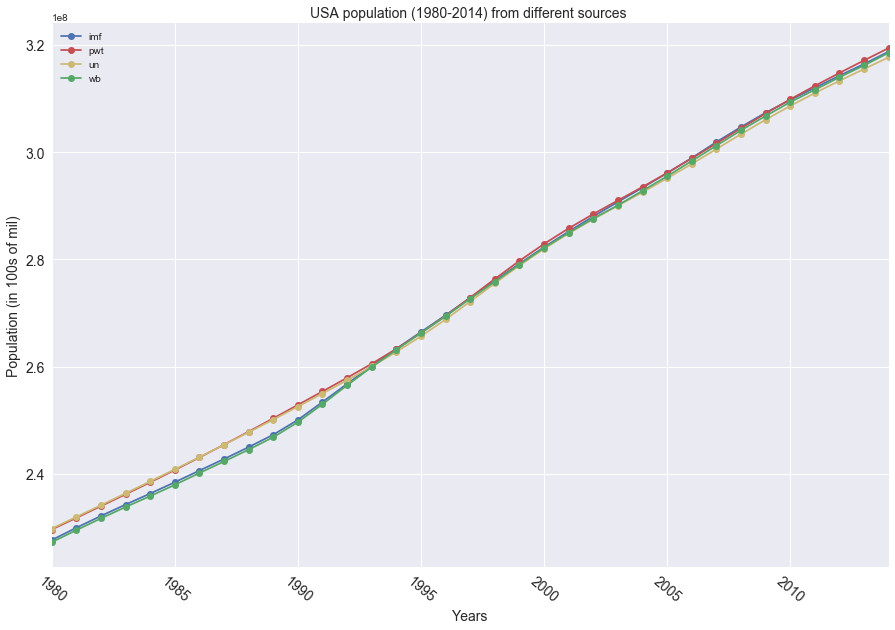

In [245]:
plt.close()

a = df_usa.plot(style=['bo-','ro-', 'yo-', 'go-'], figsize=(15,10), fontsize=14, grid=True, rot=320, colormap='tab10')
# pwt9.set_index(['countrycode', 'year']).unstack('year')['rgdpe_pc'].loc[['IND', 'IDN', 'BRA', 'CHN']].T.plot(style='*')

type(a)
a.set_xlabel('Years', fontsize=14)
a.set_ylabel('Population (in 100s of mil)', fontsize=14)
a.set_title('USA population (1980-2014) from different sources ', fontsize=14)

## Find the country with largest spread for 2010

### Get Brazil/BRA data

In [246]:
wb_bra = df_wb.loc['BRA'][21:56] # seems like absolute value to me
un_bra = df_un.loc['BRA'][31:66] * 10 **3

In [247]:
un_bra.get_values()[1]
type(un_bra.index) == pd.core.indexes.numeric.Float64Index

False

In [248]:
imf_bra = df_imf.loc['BRA'][1:36] * 10**6

In [249]:
pwt_bra = df_pwt.loc['BRA'][31:] * 10**6 # 1980 to 2014, 35 years
assert pwt_bra.shape == wb_bra.shape == imf_bra.shape == un_bra.shape

In [250]:
for _df in [pwt_bra, wb_bra, un_bra, imf_bra]:
    if type(_df.index) != pd.core.indexes.numeric.Float64Index:
        _df.index = _df.index.map(float)
        
for _df in [pwt_bra, wb_bra, un_bra, imf_bra]:
    print (type(_df.index))

<class 'pandas.core.indexes.numeric.Float64Index'>
<class 'pandas.core.indexes.numeric.Float64Index'>
<class 'pandas.core.indexes.numeric.Float64Index'>
<class 'pandas.core.indexes.numeric.Float64Index'>


In [251]:
(un_bra-wb_bra).get_values()

array([0.0, 0.0, 0.0, 0.0, 1.4901161193847656e-08, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 2.9802322387695312e-08, 0.0, 2.9802322387695312e-08, 0.0,
       -2.9802322387695312e-08, 0.0, 0.0, 2.9802322387695312e-08, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

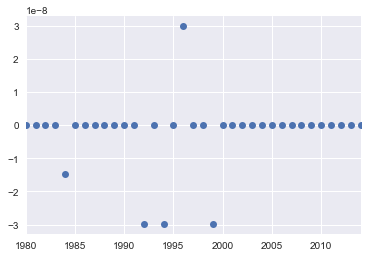

In [252]:
# Plot difference 
wb_un_diff = wb_bra-un_bra
wb_un_diff.plot(style='o')

In [253]:
df1 = pd.DataFrame({'pwt': pwt_bra, 
                   'wb': wb_bra, 
                   'un': un_bra,
                   'imf': imf_bra})

#pd.concat([cpwt, cwb, cun, cimf], axis=1)

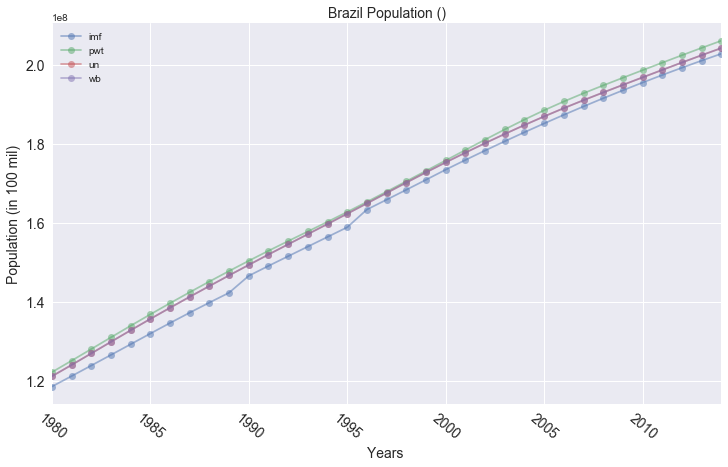

In [254]:
p1 = df1.plot(style='o-', figsize=(12,7), fontsize=14, alpha=.5, grid=True, rot=320, colormap='Set1')

label_axes(p1, '', '100 mil', 'Brazil')


In [255]:
df1.isnull().sum()
# no nan values!

imf    0
pwt    0
un     0
wb     0
dtype: int64

## Compare total population

### Get only years 1980-2014

In [256]:
cols_of_interest = ['country_name']
years = [str(y) for y in range(1980, 2015)]
cols_of_interest.extend(years)

In [257]:
ds = [df_pwt, df_wb, df_un, df_imf]

In [258]:
df_pwt

,country_name,1950,1951,1952,1953,1954,1955,1956,1957,1958,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
iso,,,,,,,,,,,,,,,,,,,,,
ALB,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.082172,3.050741,3.010849,2.968026,2.929886,2.901883,2.886010,2.880667,2.883281,2.889676
DZA,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.267887,33.749328,34.261971,34.811059,35.401790,36.036159,36.717132,37.439427,38.186135,38.934334
AGO,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.912942,18.541467,19.183907,19.842251,20.520103,21.219954,21.942296,22.685632,23.448202,24.227524
AIA,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.012637,0.012903,0.013145,0.013365,0.013571,0.013768,0.013956,0.014133,0.014300,0.014460
ATG,Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.082565,0.083467,0.084397,0.085350,0.086300,0.087233,0.088152,0.089069,0.089985,0.090900
ARG,Argentina,17.158029,17.525200,17.884976,18.238994,18.588894,18.936311,19.280156,19.619336,19.955487,...,39.145491,39.558750,39.969903,40.381860,40.798641,41.222875,41.655616,42.095224,42.538304,42.980026
ARM,Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.014917,3.002161,2.988117,2.975029,2.966108,2.963496,2.967984,2.978339,2.992192,3.006154
ABW,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100031,0.100830,0.101218,0.101342,0.101416,0.101597,0.101936,0.102393,0.102921,0.103441
AUS,Australia,8.427065,8.675029,8.859130,9.029064,9.239138,9.456325,9.684162,9.900220,10.106834,...,20.274282,20.606228,20.975949,21.370348,21.770690,22.162863,22.542371,22.911375,23.270465,23.622353


In [259]:
## Convert imf years from int to str (to be consistent with other datasets)
df_imf.columns = map(str, df_imf.columns)
df_imf.columns

Index(['country_name', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', 'country_code'],
      dtype='object')

In [260]:
for dd in ds:
    print(dd[cols_of_interest].shape)

(183, 36)
(217, 36)
(233, 36)
(194, 36)


In [261]:
# df_pwt

In [262]:
# df_pwt.iloc[:182,:]

In [263]:
total_pwt_pop_row = df_pwt.iloc[:182, 31:].sum(axis=0, numeric_only=True)

In [264]:
# Calculate total values for PWT, UN and Wb. IMF has them
# Check these match with sum calculated via Excel

# this method didn't work for me
#df_pwt.append({'Total3': total_pwt_pop_row}, ignore_index=True)

# df_imf.append(df_imf.sum(skipna=True, numeric_only=True), ignore_index=True)
# # source https://stackoverflow.com/questions/21752399/pandas-dataframe-total-row

In [265]:
df_pwt.loc['Total_pd'] = df_pwt.iloc[:182, 1:].sum()
#df_pwt

# total calculated via pd vs excel is same..

In [266]:
# country specific
def get_row_by_country_name(_df, country_name):
    # Get country by name
    return _df[_df['country_name'] == country_name]

In [267]:
# get only columns of interest
cols_for_total = [str(y) for y in range(1980, 2015)]

### a) PWT total

In [268]:
pwt_total = get_row_by_country_name(df_pwt, 'Total')[cols_for_total].reset_index()

#pwt_sub.insert(0, 'source', 'pwt')
del pwt_total['iso']
pwt_total

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,4067.792483,4143.257371,4220.377104,4299.388723,4380.569063,4464.010935,4549.851998,4637.781818,4726.781921,4826.84662,...,6423.692232,6502.565145,6582.438253,6663.083371,6744.362187,6826.078342,6907.928139,6990.183842,7072.456671,7154.701081


### b) WB Total

In [269]:
# WB Total
df_wb
df_wb.loc['Total'] = df_wb.iloc[:, 1:].sum()
wb_total = df_wb[cols_for_total].loc['Total']
#wb_total.to_dict()

### c) IMF Total

In [270]:
imf_total = get_row_by_country_name(df_imf, 'Total').reset_index()[cols_for_total]
imf_total

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,3996.821,4069.095,4144.355,4218.711,4292.474,4368.624,4447.162,4527.179,4605.502,4835.87,...,6406.832,6486.862,6569.934,6649.709,6729.132,6808.318,6868.647,6953.668,7034.943,7116.69


### d) UN total

In [271]:
un_total =df_un[cols_of_interest].iloc[:, 1:].sum()
un_total.to_dict() # pd.Series

{'1980': 4458411.5340000037,
 '1981': 4537845.7769999998,
 '1982': 4618776.1680000005,
 '1983': 4701530.8429999994,
 '1984': 4786483.8619999988,
 '1985': 4873781.7960000029,
 '1986': 4963633.2279999992,
 '1987': 5055636.1320000011,
 '1988': 5148556.956000003,
 '1989': 5240735.1169999996,
 '1990': 5330943.46,
 '1991': 5418758.8029999975,
 '1992': 5504401.1489999946,
 '1993': 5588094.8370000059,
 '1994': 5670319.7029999979,
 '1995': 5751474.4160000002,
 '1996': 5831565.0199999996,
 '1997': 5910566.294999999,
 '1998': 5988846.1029999964,
 '1999': 6066867.3910000017,
 '2000': 6145006.9890000001,
 '2001': 6223412.157999998,
 '2002': 6302149.6390000032,
 '2003': 6381408.9869999979,
 '2004': 6461370.865000003,
 '2005': 6542159.3830000032,
 '2006': 6623847.9130000016,
 '2007': 6706418.5930000022,
 '2008': 6789771.2530000033,
 '2009': 6873741.0540000014,
 '2010': 6958169.1589999981,
 '2011': 7043008.5860000011,
 '2012': 7128176.9350000015,
 '2013': 7213426.4520000014,
 '2014': 7298453.032999993

In [272]:
imf_total = imf_total.loc[0] # convert to series

In [273]:
df_pop_total = pd.DataFrame({
    'un': un_total* 10**3,
    'wb': wb_total,
    'imf': imf_total*10**6,
    'pwt': pwt_total.loc[0]*10**6
})

df_pop_total.to_csv('combined_data/total_population_all_sources.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'combined_data/total_population_all_sources.csv'

In [ ]:
plt.close()

a = df_pop_total.plot(style=['bo-','ro-', 'yo-', 'go-'], figsize=(15,10), fontsize=14, grid=True, rot=320, colormap='tab10')
# pwt9.set_index(['countrycode', 'year']).unstack('year')['rgdpe_pc'].loc[['IND', 'IDN', 'BRA', 'CHN']].T.plot(style='*')

type(a)
a.set_xlabel('Years', fontsize=14)
a.set_ylabel('Total population (in billion)', fontsize=14)
a.set_title('Total Population (1980-2014) from different sources', fontsize=14)


In [ ]:
plt.close()

a = df_pop_total.plot(style=['bs-','ro-', 'y^-', 'g*'], figsize=(15,10), fontsize=14, grid=True, rot=320, colormap='tab10')
# pwt9.set_index(['countrycode', 'year']).unstack('year')['rgdpe_pc'].loc[['IND', 'IDN', 'BRA', 'CHN']].T.plot(style='*')

type(a)
a.set_xlabel('Years', fontsize=14)
a.set_ylabel('Total population (in billion)', fontsize=14)
a.set_title('Total Population (1980-2014) from different sources', fontsize=14)


In [ ]:
#sns.reset_orig() -> removes seaborn touch of gray background!


In [ ]:
df_pop_total.plot(kind='scatter', x='pwt', y='imf', c='un', s=50);


#### Why does WB have higher population than others? (verify summing process was correct)

### Compare growth rate values of total population

### Calculate percent change!


In [ ]:
# calculate percent change!
    
print(df_pop_total['wb'].pct_change().tolist())

In [ ]:
test = df_pop_total['wb'].head()
(test[2]-test[1])*1.0 / test[1]
pct_del = lambda _s, idx: (_s[idx]-_s[idx-1]*1.0)/_s[idx-1]
print(pct_del(test,3))
print(pct_del(test,2))
print(pct_del(test,1))

## Create Multi-Index of 4 Data sets to convert to xarray

Mike's guide:

Restructure pd dataframe so these are indexes

    country_code
    year
    source

cols as variable names
index as dimensions

    1. Each df drop everything that's not a year [x]
    
country_name is meta data to country_code -> let's drop country_name (easiet)

    2. Set the name of the columns to be quote 'year'

`df.column.name = 'year'` set column index

    3. `df.stack('year')` -> will return series (with two indices iso and year) with single value for iso-year combo

    4. pd.concat(
        {
            'wb': serires,
            'pwt': ..,
        }, axis=0, names=['source'])

names -> name of resulting index

#join all series along 0 axis

In [ ]:
def is_year(_y):
    try:
        float(_y)
        return True
    except ValueError:
        return False

In [ ]:
assert is_year('1950') == True
assert is_year(1950) == True
assert is_year('country_name') == False

## 1. Drop all non-years

In [ ]:
def drop_non_years(_df):
    def _is_year(_y):
        try:
            float(_y)
            return True
        except ValueError:
            return False
    return _df[[x for x in _df.columns if _is_year(x)]] 

In [ ]:
df_pwt_yr = drop_non_years(df_pwt)
df_imf_yr = drop_non_years(df_imf)
df_wb_yr = drop_non_years(df_wb)
df_un_yr = drop_non_years(df_un)

In [ ]:
df_pwt_yr.columns = df_pwt_yr.columns.astype(int)
df_imf_yr.columns = df_imf_yr.columns.astype(int)
df_wb_yr.columns = df_wb_yr.columns.astype(int)
df_un_yr.columns = df_un_yr.columns.astype(int)

In [ ]:
# df_wb_yr # checked with excel data
# df_un_yr

In [ ]:
# might no longer be necessary due to drop_non_years
#del df_imf['country_code']

## 2. Set the name of the columns to be quote 'year'

In [ ]:
def set_year_as_col_name(_df):
    _df.columns.name = 'year'
    return _df

In [ ]:
ls_of_df_yrs = [df_pwt_yr, df_imf_yr, df_wb_yr, df_un_yr]

In [ ]:
# df_test = df_pwt_yr.copy()
# df_test.columns.name = 'year'
# df_test

In [ ]:
#lazy to name explicitly
[pwt_source, imf_source, wb_source, un_source] = [set_year_as_col_name(_df) for _df in ls_of_df_yrs]

### 3. Stack year

In [ ]:
def stack_year(_df):
    return _df.stack('year')

#`df.stack('year')` -> will return series (with two indices iso and year) with single value for iso-year combo

### 3.5 Convert units

In [ ]:
pwt_source = pwt_source * 10**6 
imf_source = imf_source * 10**6
wb_source = wb_source
un_source = un_source * 10**3

### 4. Concat all munged, multiindex `sources`

In [ ]:
# order is: pwt, imf, wb, un

combined = pd.concat({
    'pwt': stack_year(pwt_source),
    'imf': stack_year(imf_source),
    'wb': stack_year(wb_source),
    'un': stack_year(un_source)}, axis=0, names=['source'])

In [ ]:
combined.index.get_level_values('iso')
final = combined[combined.index.get_level_values('iso') != 'Total']
final = final[np.in1d(final.index.get_level_values('iso'), ['Total', 'World', 'Total_pd', np.nan, 'nan'], invert=True)]
final = final[~pd.isnull(final.index.get_level_values('iso'))]

# World, 

#print(final.index.get_level_values('iso').unique().tolist())

# all values in each row of df
final

In [ ]:
da = final.to_xarray()
da

In [ ]:
da.isnull().any(dim='source')

In [ ]:
# 2010 data for countries with complete coverage across all datasets
complete_coverage_2010 = da.sel(iso=da.iso[~da.sel(year=2010).isnull().any(dim='source')], year=2010)
complete_coverage_2010

In [ ]:
# variance (a measure of spread) across sources, indexed by iso (single number per iso)
complete_coverage_2010.var(dim='source').argmax(dim='iso') #-> positional index of max value (30th country)

# isel -> positional selection along given dimension

# alternatively, can do max - min to get spread
#complete_coverage_2010.max(dim='source') - complete_coverage_2010.min(dim='source')


In [ ]:
# Mike's one liner
complete_coverage_2010.isel(
    iso=complete_coverage_2010.var(dim='source').argmax(dim='iso'))

# returns China values

In [ ]:
da.sel(year=2010, iso='CHN').max(dim='source') - da.sel(year=2010, iso='CHN').min(dim='source') 

In [ ]:
da.sel(year=2010, iso='CHN')

In [ ]:
da.sel(year=2010, iso='IND').max(dim='source') - da.sel(year=2010, iso='IND').min(dim='source') 

In [ ]:
da.sel(year=2010, iso='IND')

In [ ]:
## China!

In [ ]:
china = da.sel(iso='CHN').to_series().unstack('source')
china.plot(style='*', figsize=(15,10), grid=True, rot=320, alpha=.5, ms=12, colormap='tab10')

In [ ]:
china = da.sel(iso='CHN').to_series().unstack('source')
china.plot(style='*', figsize=(15,10), grid=True, rot=320, alpha=.5, ms=12, colormap='tab10')

In [ ]:
## India Line plot by sourcd

In [ ]:
india = da.sel(iso='IND').to_series().unstack('source')
(abs(india['wb'] - india['un']).fillna(0) < 1e-3).all() # no difference
india

(india['pwt'] - india['un']).plot(style='o', figsize=(12,10)) 
# india

In [ ]:
da.sel(iso='IND').to_series().unstack('source').plot(style='*', figsize=(15,10), grid=True, rot=320, alpha=.5, ms=12, colormap='tab10')

### USA!

In [ ]:
usa = da.sel(iso='USA').to_series().unstack('source')
b = usa.plot(style=['b*-','r*-', 'y*-', 'g*-'], figsize=(15,10), grid=True, rot=320, alpha=.5, ms=10, colormap='tab10')
b.set_xlabel('Years', fontsize=14)
b.set_ylabel('USA Population (in 100s of mil)', fontsize=14)
b.set_title('USA Population from Different Sources', fontsize=14)